In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image



class handDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        # self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        masks = []
        for i in range(1,5):
            mask_path = os.path.join(self.root, "masks", str(i), self.imgs[idx])
            if os.path.isfile(mask_path):
                mask_tmp = np.array(Image.open(mask_path))
                masks.append(mask_tmp > 0)
        assert len(masks) > 0, print(self.imgs[idx] + " has no mask")

        masks= np.array(masks)
        # mask = np.array(mask)
        # # instances are encoded as different colors
        # obj_ids = np.unique(mask)
        # # first id is the background, so remove it
        # obj_ids = obj_ids[1:]
        # # split the color-encoded mask into a set
        # # of binary masks
        # masks = mask == obj_ids[:, None, None]
        # # get bounding box coordinates for each mask
        num_objs = masks.shape[0]
        boxes = []
        areas = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = int(np.min(pos[1]))
            xmax = int(np.max(pos[1]))
            ymin = int(np.min(pos[0]))
            ymax = int(np.max(pos[0]))
            assert xmax > xmin and ymax > ymin, print("empty rectangle for " + self.imgs[idx])
            areas.append((xmax - xmin)*(ymax - ymin))
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.int32)
        areas = torch.as_tensor(areas, dtype=torch.int32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)




In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [3]:
from matplotlib.pyplot import imshow
dataset = handDataset('./')
dataset[0]
# for i in range(13,25):
#     print(i)
#     img, data = dataset[i]
#     pix = np.array(img)
#     mask = data['masks'].cpu().numpy()
#     boxes = data['boxes'].cpu().numpy()
#     print(boxes.shape)
#     print(mask.shape)
#     # pix= pix.reshape((pix.shape[2], pix.shape[1], pix.shape[0]))
#     print(pix.shape)
#     # for j in range(boxes.shape[0]):
#     #     cv2.rectangle(pix, (boxes[j][0], boxes[j][3]), (boxes[j][2], boxes[j][1]), (255, 255, 0), 1)
#     masks = (mask[0] != 0)
#     for j in range(1, mask.shape[0]):
#         masks = masks | (mask[j] != 0)
#     print(masks.shape)
#     pix[(masks != 0)] = 255
#     imshow(pix)


(<PIL.Image.Image image mode=RGB size=1280x720 at 0x7EFB84BB8C40>,
 {'boxes': tensor([[626, 160, 850, 434]], dtype=torch.int32),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([61376], dtype=torch.int32),
  'iscrowd': tensor([0])})

In [4]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [21]:
len(dataset)

817

In [5]:
# use our dataset and defined transformations
dataset = handDataset('./', get_transform(train=True))
dataset_test = handDataset('./', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-150])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-150:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=16,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=16,
    collate_fn=utils.collate_fn)

In [6]:
device = torch.device('cuda')
# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.2)

In [7]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'weights/model_best.tar')

In [8]:
  start_epoch = 0
  resume = 'weights/best_checkpoint.tar'
  checkpoint = torch.load(resume)
  start_epoch = checkpoint['epoch']
  model.load_state_dict(checkpoint['state_dict'])
#   optimizer.load_state_dict(checkpoint['optimizer'])
  print("=> loaded checkpoint '{}' (epoch {})" .format(resume, checkpoint['epoch']))

=> loaded checkpoint 'weights/best_checkpoint.tar' (epoch 9)


In [9]:
start_epoch

9

In [25]:
start_epoch = 0

In [9]:
res = evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [0/5]  eta: 0:00:09  model_time: 1.5840 (1.5840)  evaluator_time: 0.0700 (0.0700)  time: 1.9401  data: 0.2510  max mem: 2357
Test:  [4/5]  eta: 0:00:00  model_time: 0.3570 (0.6009)  evaluator_time: 0.0590 (0.0606)  time: 0.9291  data: 0.2503  max mem: 2358
Test: Total time: 0:00:04 (0.9299 s / it)
Averaged stats: model_time: 0.3570 (0.6009)  evaluator_time: 0.0590 (0.0606)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.915
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDet

In [32]:
res.coco_eval['segm'].params.iouType

'segm'

In [28]:
res.coco_eval['segm'].stats 

array([ 0.72885384,  0.99434078,  0.91681999, -1.        ,  0.52710985,
        0.74587011,  0.24477612,  0.75671642,  0.75671642, -1.        ,
        0.6       ,  0.775     ])

In [33]:
res.coco_eval['segm'].stats[0]

0.728853843376946

In [26]:
# let's train it for 10 epochs
num_epochs = 18
bestIOU = 0.5
for epoch in range(start_epoch, num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)
    iou50to95 = res.coco_eval['segm'].stats[0]
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict(),},
        False, 
        filename='weights/checkpoint_' + str(epoch+1) + '.tar')
    if(bestIOU < iou50to95):
        print("best IOU: " + str(iou50to95) + "\n\n\n")
        print("at epoch: " + str(epoch) + "\n\n\n")
        bestIOU = iou50to95
        save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict(),},
        False, 
        filename='weights/best_checkpoint.tar')
        

Epoch: [0]  [  0/205]  eta: 0:07:38  lr: 0.000006  loss: 0.1882 (0.1882)  loss_classifier: 0.0403 (0.0403)  loss_box_reg: 0.0391 (0.0391)  loss_mask: 0.1061 (0.1061)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 2.2371  data: 0.6735  max mem: 5095
Epoch: [0]  [100/205]  eta: 0:01:12  lr: 0.000496  loss: 0.0887 (0.1272)  loss_classifier: 0.0092 (0.0203)  loss_box_reg: 0.0047 (0.0147)  loss_mask: 0.0727 (0.0893)  loss_objectness: 0.0001 (0.0005)  loss_rpn_box_reg: 0.0018 (0.0024)  time: 0.6801  data: 0.0076  max mem: 5375
Epoch: [0]  [200/205]  eta: 0:00:03  lr: 0.000985  loss: 0.0842 (0.1116)  loss_classifier: 0.0081 (0.0168)  loss_box_reg: 0.0031 (0.0104)  loss_mask: 0.0680 (0.0820)  loss_objectness: 0.0001 (0.0005)  loss_rpn_box_reg: 0.0015 (0.0020)  time: 0.6821  data: 0.0078  max mem: 5375
Epoch: [0]  [204/205]  eta: 0:00:00  lr: 0.001000  loss: 0.0837 (0.1109)  loss_classifier: 0.0081 (0.0166)  loss_box_reg: 0.0031 (0.0102)  loss_mask: 0.0675 (0.0816) 

Epoch: [2]  [204/205]  eta: 0:00:00  lr: 0.001000  loss: 0.0701 (0.0753)  loss_classifier: 0.0067 (0.0084)  loss_box_reg: 0.0026 (0.0036)  loss_mask: 0.0586 (0.0619)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0013 (0.0012)  time: 0.6580  data: 0.0075  max mem: 5375
Epoch: [2] Total time: 0:02:21 (0.6918 s / it)
creating index...
index created!
Test:  [ 0/38]  eta: 0:00:47  model_time: 0.2900 (0.2900)  evaluator_time: 0.0089 (0.0089)  time: 1.2463  data: 0.8616  max mem: 5375
Test:  [37/38]  eta: 0:00:00  model_time: 0.2721 (0.2692)  evaluator_time: 0.0080 (0.0081)  time: 0.2837  data: 0.0051  max mem: 5375
Test: Total time: 0:00:11 (0.3151 s / it)
Averaged stats: model_time: 0.2721 (0.2692)  evaluator_time: 0.0080 (0.0081)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.905
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

best IOU: 0.9456397618647089



at epoch: 4



Epoch: [5]  [  0/205]  eta: 0:04:54  lr: 0.000200  loss: 0.0715 (0.0715)  loss_classifier: 0.0074 (0.0074)  loss_box_reg: 0.0029 (0.0029)  loss_mask: 0.0605 (0.0605)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.4343  data: 0.6814  max mem: 5375
Epoch: [5]  [100/205]  eta: 0:01:12  lr: 0.000200  loss: 0.0657 (0.0700)  loss_classifier: 0.0069 (0.0081)  loss_box_reg: 0.0018 (0.0026)  loss_mask: 0.0560 (0.0581)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 0.6847  data: 0.0084  max mem: 5375
Epoch: [5]  [200/205]  eta: 0:00:03  lr: 0.000200  loss: 0.0682 (0.0707)  loss_classifier: 0.0070 (0.0078)  loss_box_reg: 0.0020 (0.0029)  loss_mask: 0.0581 (0.0587)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0012 (0.0011)  time: 0.6833  data: 0.0081  max mem: 5375
Epoch: [5]  [204/205]  eta: 0:00:00  lr: 0.000200  loss: 0.0683 (0.0707)  loss_classifier: 0.0070 (0.0078)  loss_box_re

Epoch: [7]  [204/205]  eta: 0:00:00  lr: 0.000040  loss: 0.0650 (0.0701)  loss_classifier: 0.0060 (0.0075)  loss_box_reg: 0.0017 (0.0028)  loss_mask: 0.0563 (0.0586)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0008 (0.0011)  time: 0.6597  data: 0.0077  max mem: 5375
Epoch: [7] Total time: 0:02:20 (0.6849 s / it)
creating index...
index created!
Test:  [ 0/38]  eta: 0:00:39  model_time: 0.2968 (0.2968)  evaluator_time: 0.0096 (0.0096)  time: 1.0430  data: 0.6720  max mem: 5375
Test:  [37/38]  eta: 0:00:00  model_time: 0.2724 (0.2698)  evaluator_time: 0.0083 (0.0084)  time: 0.2858  data: 0.0066  max mem: 5375
Test: Total time: 0:00:11 (0.3117 s / it)
Averaged stats: model_time: 0.2724 (0.2698)  evaluator_time: 0.0083 (0.0084)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.918
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [10]  [  0/205]  eta: 0:04:43  lr: 0.000008  loss: 0.0685 (0.0685)  loss_classifier: 0.0100 (0.0100)  loss_box_reg: 0.0016 (0.0016)  loss_mask: 0.0562 (0.0562)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.3828  data: 0.6312  max mem: 5375
Epoch: [10]  [100/205]  eta: 0:01:12  lr: 0.000008  loss: 0.0672 (0.0690)  loss_classifier: 0.0064 (0.0070)  loss_box_reg: 0.0020 (0.0026)  loss_mask: 0.0557 (0.0583)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0009 (0.0011)  time: 0.6826  data: 0.0079  max mem: 5375
Epoch: [10]  [200/205]  eta: 0:00:03  lr: 0.000008  loss: 0.0667 (0.0701)  loss_classifier: 0.0061 (0.0076)  loss_box_reg: 0.0018 (0.0028)  loss_mask: 0.0577 (0.0585)  loss_objectness: 0.0000 (0.0002)  loss_rpn_box_reg: 0.0009 (0.0011)  time: 0.6840  data: 0.0079  max mem: 5375
Epoch: [10]  [204/205]  eta: 0:00:00  lr: 0.000008  loss: 0.0667 (0.0700)  loss_classifier: 0.0060 (0.0076)  loss_box_reg: 0.0018 (0.0028)  loss_mask: 0.0561 (0.05

creating index...
index created!
Test:  [ 0/38]  eta: 0:00:39  model_time: 0.3278 (0.3278)  evaluator_time: 0.0093 (0.0093)  time: 1.0464  data: 0.6475  max mem: 5375
Test:  [37/38]  eta: 0:00:00  model_time: 0.2722 (0.2708)  evaluator_time: 0.0082 (0.0084)  time: 0.2852  data: 0.0062  max mem: 5375
Test: Total time: 0:00:11 (0.3122 s / it)
Averaged stats: model_time: 0.2722 (0.2708)  evaluator_time: 0.0082 (0.0084)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.920
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | m

Epoch: [15]  [  0/205]  eta: 0:04:49  lr: 0.000000  loss: 0.0684 (0.0684)  loss_classifier: 0.0082 (0.0082)  loss_box_reg: 0.0020 (0.0020)  loss_mask: 0.0574 (0.0574)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 1.4103  data: 0.6375  max mem: 5375
Epoch: [15]  [100/205]  eta: 0:01:12  lr: 0.000000  loss: 0.0676 (0.0705)  loss_classifier: 0.0061 (0.0073)  loss_box_reg: 0.0022 (0.0031)  loss_mask: 0.0575 (0.0588)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 0.6840  data: 0.0082  max mem: 5375
Epoch: [15]  [200/205]  eta: 0:00:03  lr: 0.000000  loss: 0.0670 (0.0701)  loss_classifier: 0.0062 (0.0076)  loss_box_reg: 0.0019 (0.0028)  loss_mask: 0.0566 (0.0584)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0010 (0.0011)  time: 0.6830  data: 0.0081  max mem: 5375
Epoch: [15]  [204/205]  eta: 0:00:00  lr: 0.000000  loss: 0.0683 (0.0702)  loss_classifier: 0.0068 (0.0076)  loss_box_reg: 0.0021 (0.0028)  loss_mask: 0.0568 (0.05

creating index...
index created!
Test:  [ 0/38]  eta: 0:00:40  model_time: 0.3070 (0.3070)  evaluator_time: 0.0090 (0.0090)  time: 1.0622  data: 0.6798  max mem: 5375
Test:  [37/38]  eta: 0:00:00  model_time: 0.2720 (0.2700)  evaluator_time: 0.0081 (0.0083)  time: 0.2832  data: 0.0045  max mem: 5375
Test: Total time: 0:00:11 (0.3121 s / it)
Averaged stats: model_time: 0.2720 (0.2700)  evaluator_time: 0.0081 (0.0083)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.920
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | m

In [0]:
exit here

In [27]:
# pick one image from the test set
img, _ = dataset_test[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [0]:
  start_epoch = 0
  resume = 'weights/checkpoint_best.tar'
  checkpoint = torch.load(resume)
  start_epoch = checkpoint['epoch']
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  print("=> loaded checkpoint '{}' (epoch {})" .format(resume, checkpoint['epoch']))

15
(1, 4)
(1, 720, 1280)
(720, 1280, 3)
[0.]
(720, 1280)


<ipython-input-15-2f3ec672b829>:16: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(pix, (boxes[j][0], boxes[j][3]), (boxes[j][2], boxes[j][1]), (255, 255, 0), 5)


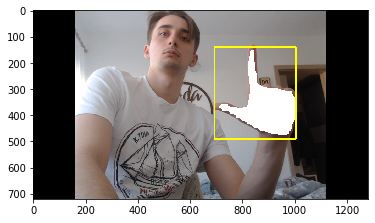

In [15]:
import cv2
i=15
model.eval()
print(i)
img, _ = dataset_test[i]
with torch.no_grad():
  prediction = model([img.to(device)])
pix = img.mul(255).permute(1, 2, 0).byte().numpy()
mask = prediction[0]['masks'].permute(1, 0, 2, 3)[0].cpu().detach().numpy()
boxes = prediction[0]['boxes'].cpu().detach().numpy()
print(boxes.shape)
print(mask.shape)
# pix= pix.reshape((pix.shape[2], pix.shape[1], pix.shape[0]))
print(pix.shape)
for j in range(boxes.shape[0]):
     cv2.rectangle(pix, (boxes[j][0], boxes[j][3]), (boxes[j][2], boxes[j][1]), (255, 255, 0), 5)
print(mask[:,700,20])
accuracy = 0.95
masks = (mask[0] > accuracy)
for j in range(1, mask.shape[0]):
    masks = masks | (mask[j] > accuracy)
print(masks.shape)
pix[(masks > accuracy)] = 255
imshow(pix)

In [0]:
prediction

[{'boxes': tensor([[492.8997, 168.4137, 908.6821, 441.7151],
          [692.2997, 453.7940, 833.0519, 602.3800],
          [518.2817, 448.3114, 663.7862, 622.4246]], device='cuda:0'),
  'labels': tensor([1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0

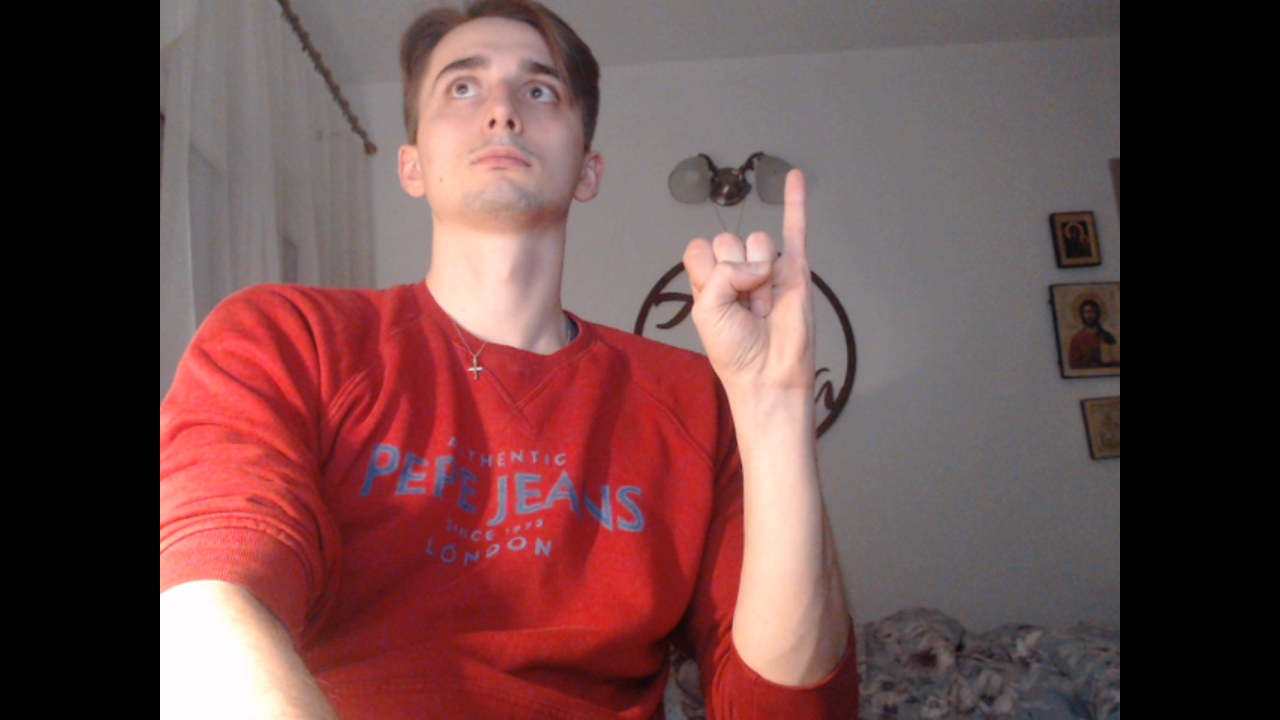

In [11]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

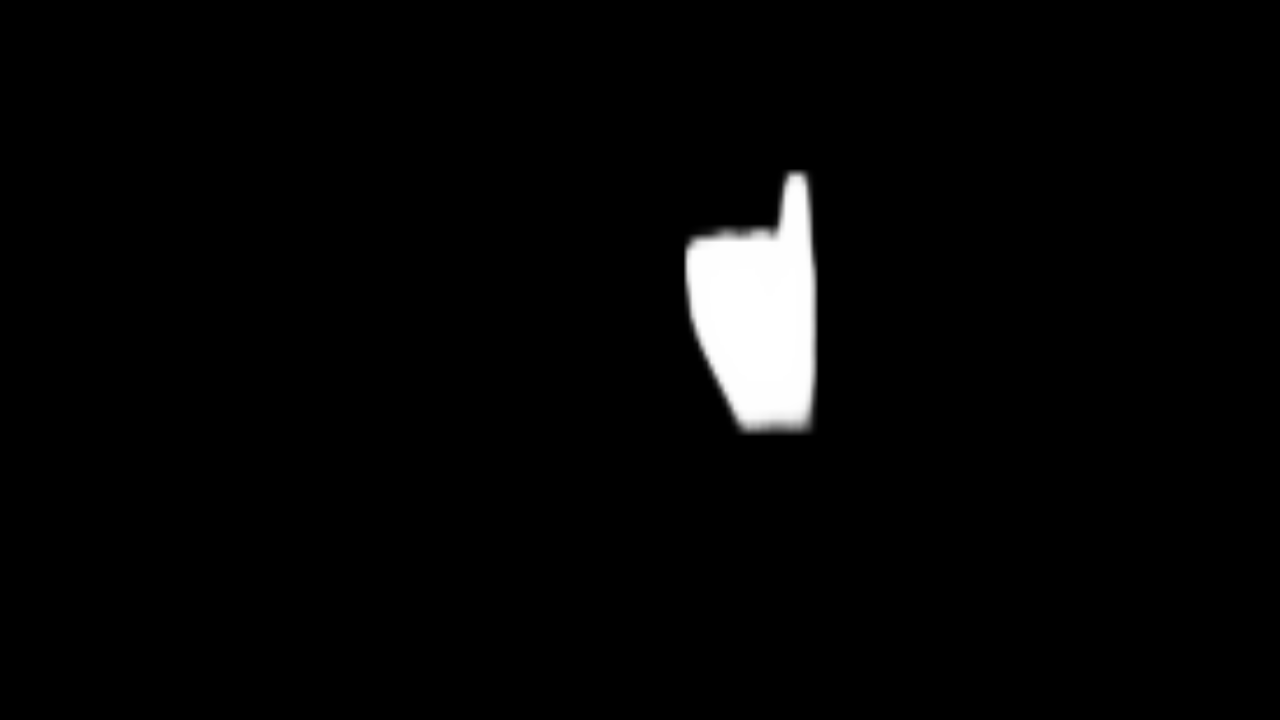

In [12]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [0]:
resume = False
if resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args.resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

In [21]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return binary

ModuleNotFoundError: No module named 'google'

In [0]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo_2(filename='photo.jpg', quality=0.8, size=(960,720)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))

In [137]:
from google.colab.patches import cv2_imshow
try:
  model.eval()
  photo = take_photo_2()
  # cv2_imshow(photo)
  offset_w = 160 #int((1280-960)/2)
  result = np.zeros((720,1280,3), dtype=np.float32)
  result[:,offset_w:-offset_w] = photo
  # Show the image which was just taken.
  # display(Image(filename))i=4
  # cv2_imshow(result)
  result = result *(1.0/255.0)
  result_feed = result.transpose(2,1,0)
  with torch.no_grad():
    prediction = model([torch.as_tensor(result_feed, dtype=torch.float32).to(device)])
  # pix = img.mul(255).permute(1, 2, 0).byte().numpy()
  pix = result
  mask = prediction[0]['masks'].permute(1, 0, 2, 3)[0].cpu().detach().numpy()
  boxes = prediction[0]['boxes'].cpu().detach().numpy()
  print(boxes.shape)
  print(mask.shape)
  number_of_hands = mask.shape[0]
  if(number_of_hands > 0):
    print(pix.shape)
    for j in range(boxes.shape[0]):
        cv2.rectangle(pix, (boxes[j][0], boxes[j][3]), (boxes[j][2], boxes[j][1]), (255, 255, 0), 5)
    accuracy = 0.01
    masks = (mask[0] > accuracy)
    for j in range(1, mask.shape[0]):
        masks = masks | (mask[j] > accuracy)
    print(masks.shape)
    pix[(masks > accuracy)] = 255
  imshow(pix)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

(2, 4)
(2, 1280, 720)
(720, 1280, 3)
(1280, 720)
boolean index did not match indexed array along dimension 0; dimension is 720 but corresponding boolean dimension is 1280


In [0]:
from google.colab.patches import cv2_imshow

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5500  100  5500    0     0   244k      0 --:--:-- --:--:-- --:--:--  244k


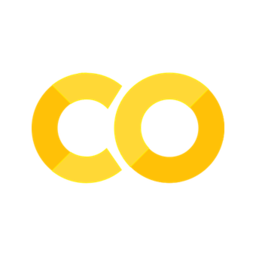

In [91]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)